# Postprocess results

In [1]:
import re
import itertools
import importlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import tifffile
import torch
import torchvision

%matplotlib inline

# plot model performance

In [2]:
def log2df(logfile, f1=True):
    epoch = 0
    row_list = []

    with open(logfile) as f:
        line = f.readline()
        while not line.startswith('[Training]'):
            line = f.readline()
        
        line = f.readline()
        while not line.startswith('==========='):
            line1 = f.readline()  # Epoch            
            epoch = re.search(r'(\d+)/', line1).group(1)
            epoch = int(epoch)
            
            line2 = f.readline()  # Train
            g = re.search(r"patch-loss: (.*) patch-Acc: (.*)", line2).group(1, 2)
            row_list.append([epoch, 'train', float(g[0]), float(g[1]), 0, 0])
            
            line3 = f.readline()  # Val
            if line3.startswith('===='):
                break
            elif line3.startswith('------'):
                continue
                    
            if f1:
                g = re.search(r"patch-loss: (.*) patch-Acc: (.*) WSI-AUC: (.*) WSI-F1: (.*)", 
                              line3).group(1, 2, 3, 4)
            else:
                g = re.search(r"patch-loss: (.*) patch-Acc: (.*) WSI-AUC: (.*) WSI-Acc: (.*)", 
                              line3).group(1, 2, 3, 4)

            row_list.append([epoch, 'val', float(g[0]), float(g[1]), float(g[2]), float(g[3])])

            line = f.readline()
            
    
    if f1:
        df = pd.DataFrame(row_list, columns=['epoch', 'phase', 'patch-loss', 'patch-acc', 'wsi-auc', 'wsi-f1'])
    else:
        df = pd.DataFrame(row_list, columns=['epoch', 'phase', 'patch-loss', 'patch-acc', 'wsi-auc', 'wsi-acc'])
    
    df2 = df[df['phase'] == 'val']
    stat = df2.iloc[-5:, :].mean()

    return df, stat

In [3]:
def plot(df, title, num_epochs, ymin=0.2, ymax=1, show=True, f1=True, figsize=(6, 5)):
#     num_epochs = df['epoch'].max()
    
    sns.set(font_scale=1.5)
    plt.figure(figsize=figsize)

    sns.lineplot(data=df, x='epoch', y='patch-loss', 
                 style='phase', style_order=['val', 'train'],
                 color='red')
    sns.lineplot(data=df, x='epoch', y='patch-acc', 
                 style='phase', style_order=['val', 'train'],
                 color='blue')

    ax = sns.lineplot(data=df[df['phase'] == 'val'], 
                 x='epoch', y='wsi-auc', color='black')
    
    if f1:
        ax = sns.lineplot(data=df[df['phase'] == 'val'], 
                 x='epoch', y='wsi-f1', color='green')
    
    ax.set_xlim(-5, num_epochs + 5)
    ax.set_ylim(ymin, ymax)
    ax.get_legend().remove()
    plt.ylabel('')
    plt.title(title)
    
    if not show:
        ax.set(xticklabels=[], xlabel=None)

In [4]:
def plot_val(df, title):
    df = df[df['phase'] == 'val']
    df2 = pd.melt(
        df, 
        id_vars='epoch', value_vars=['patch-acc', 'wsi-auc', 'wsi-f1'], 
        var_name='metric', value_name='value')
    
    plt.figure(figsize=(5, 5))
    
    ax = sns.lineplot(
        data=df2, x='epoch', y='value', hue='metric', 
        palette={'patch-acc': 'blue', 'wsi-auc': 'black', 'wsi-f1': 'green'})
    
    ax.set_ylim(0, 1)
    ax.get_legend().remove()
    plt.ylabel('')
    plt.title(title)

### 2.5X

In [44]:
# # df, stat6 = log2df('../model/overlap_2.5X/20200908_1153.log')
# # plot(df, 'Overlap_2.5X pre SGD(1e-5) data47', 200, 0, 1.1)
# df, stat6 = log2df('../model/overlap_2.5X/20200910_0036.log')
# plot(df, 'Overlap_2.5X pre SGD(1e-5) data47', 200, 0, 1.1)
# df, stat6 = log2df('../model/overlap_2.5X/20200910_1224.log')
# plot(df, 'Overlap_2.5X pre SGD(1e-5) data47', 200, 0, 1.1)

### 10X

In [45]:
# df, stat1 = log2df('../model/10X/20200804_1454.log')
# plot(df, '10X non-pre SGD lr=1e-3', 100, 0)

# df, stat3 = log2df('../model/10X/20200806_1620.log')
# plot(df, '10X non-pre SGD lr=1e-4', 100, 0)

# df, stat5 = log2df('../model/10X/20200807_1656.log')
# plot(df, '10X non-pre SGD lr=1e-5', 100, 0, show=False)
# df, stat6 = log2df('../model/10X/20200807_0814.log')
# plot(df, '10X pre SGD lr=1e-5', 100, 0)

# # df, stat5 = log2df('../model/10X/20200817_1743.log')
# # plot(df, '10X pre SGD lr=1e-5', 100, 0, show=False)
# # df, stat6 = log2df('../model/10X/20200817_1815.log')
# # plot(df, '10X pre SGD lr=1e-5 all-data', 100, 0)

### 40X

In [46]:
# df, stat1 = log2df('../model/40X/20200803_1810.log')
# plot(df, '40X pre SGD lr=1e-3', 50, 0)

# df, stat3 = log2df('../model/40X/20200807_0137.log')
# plot(df, '40X non-pre SGD lr=1e-4', 50, 0)

# df, stat5 = log2df('../model/40X/20200808_1645.log')
# plot(df, '40X non-pre SGD lr=1e-5', 100, 0, show=False)
# df, stat6 = log2df('../model/40X/20200808_0205.log')
# plot(df, '40X pre SGD lr=1e-5', 100, 0)

### MIL 2.5X

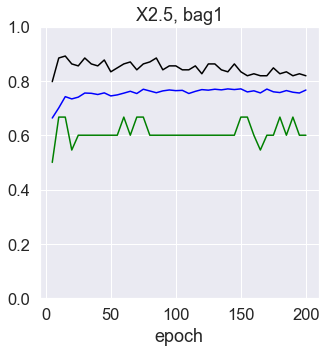

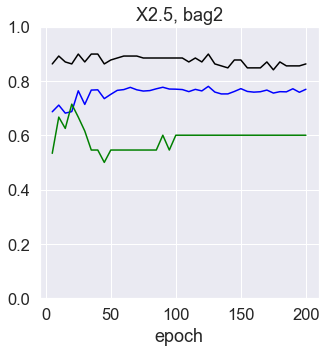

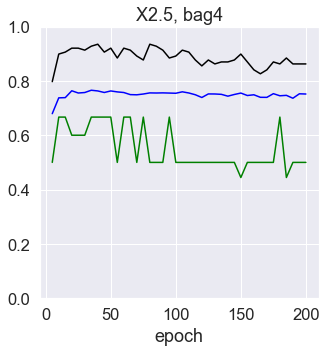

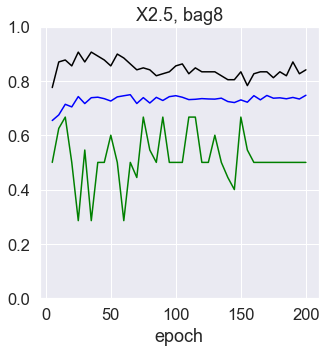

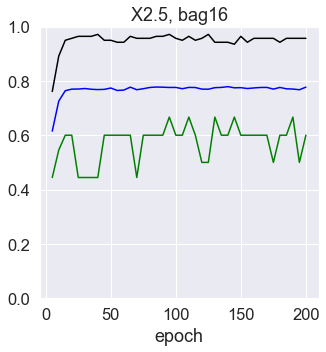

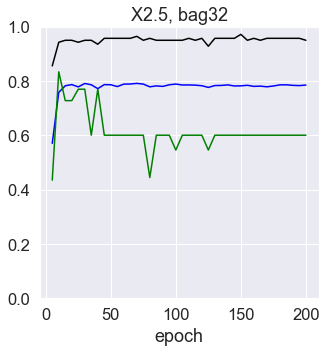

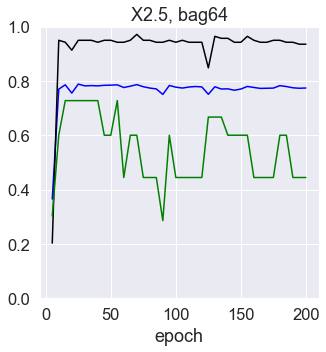

In [60]:
df1, stat1 = log2df('../model/multipatch/20201126_0809.log')
plot_val(df1, 'X2.5, bag1')
df2, stat1 = log2df('../model/multipatch/20201126_0132.log')
plot_val(df2, 'X2.5, bag2')
df3, stat1 = log2df('../model/multipatch/20201125_1855.log')
plot_val(df3, 'X2.5, bag4')
df4, stat1 = log2df('../model/multipatch/20201125_1218.log')
plot_val(df4, 'X2.5, bag8')
df5, stat1 = log2df('../model/multipatch/20201125_0545.log')
plot_val(df5, 'X2.5, bag16')
df6, stat1 = log2df('../model/multipatch/20201124_2313.log')
plot_val(df6, 'X2.5, bag32')
df7, stat1 = log2df('../model/multipatch/20201124_1641.log')
plot_val(df7, 'X2.5, bag64')

### MIL 10X

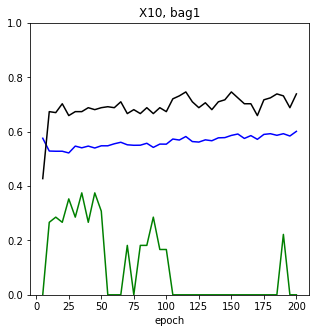

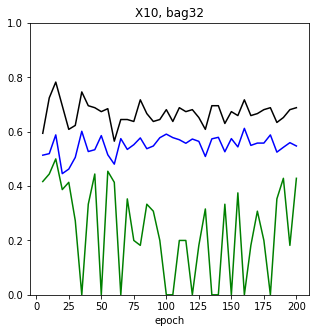

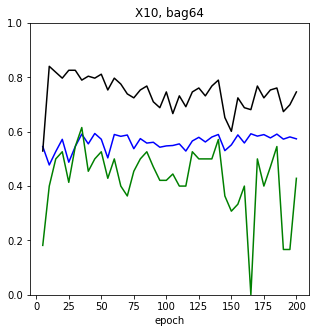

In [47]:
df1, stat1 = log2df('../model/multipatch_10X/20201126_2107.log')
plot_val(df1, 'X10, bag1')
df6, stat1 = log2df('../model/multipatch_10X/20201127_0022.log')
plot_val(df6, 'X10, bag32')
df7, stat1 = log2df('../model/multipatch_10X/20201126_1749.log')
plot_val(df7, 'X10, bag64')

### EfficientNet

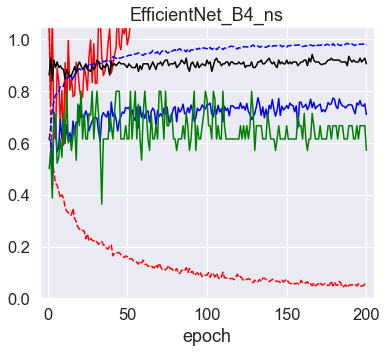

In [9]:
df, stat1 = log2df('../model/efficientnet/20201202_1754.log')
plot(df, 'EfficientNet_B4_ns', 200, 0, 1.05)
# df, stat1 = log2df('../model/2.5X/20201203_0626.log')
# plot(df, 'ResNet18', 200, 0, 1.05)

## focal loss

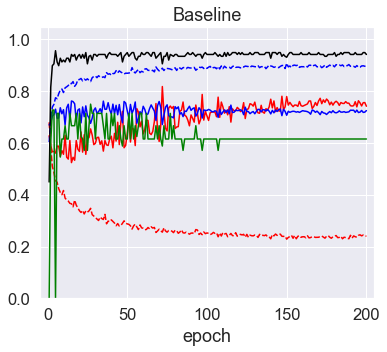

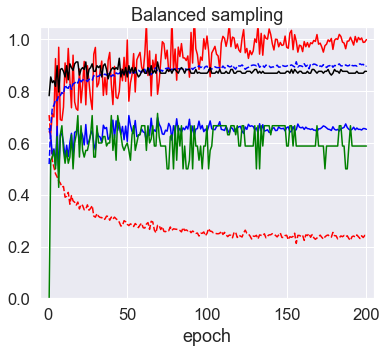

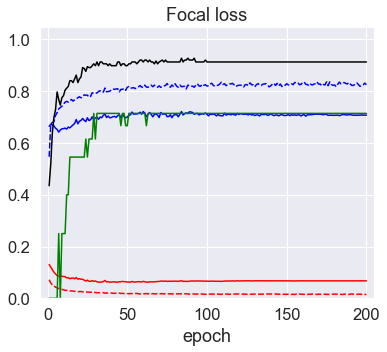

In [5]:
df, stat1 = log2df('../model/imbalance/20201203_2124.log')
plot(df, 'Baseline', 200, 0, 1.05)
df, stat1 = log2df('../model/2.5X/20201203_1649.log')
plot(df, 'Balanced sampling', 200, 0, 1.05)
df, stat1 = log2df('../model/focal/20201204_0212.log')
plot(df, 'Focal loss', 200, 0, 1.05)

# Inference

#### load model

In [2]:
from model_resnet18 import PathModel

pmodel = PathModel('../model/2.5X/20201203_0626.ini')
pmodel.net.load_state_dict(torch.load('../model/2.5X/20201203_0626_best.pth'))

logfile:       E:/PAIP2020/model/2.5X/20201203_1151.log


<All keys matched successfully>

#### inference of all WSIs

In [30]:
%%time

dataset, dataloader = pmodel.make_dataloader('../data/dataset_trainval/patch_level2.csv', 'val')
patch_loss, patch_acc, wsi_auc, wsi_f1, df, df_wsi = pmodel.infer(dataloader)

print(df.shape)
df.head(1)

(6276, 9)
Wall time: 32.7 s


,wsi,msi,prob,loss,x,y,size,level,pred
0,training_data_01,1,0.999957,0.019385,49152,65536,256,2,1


#### ajust patch threshold

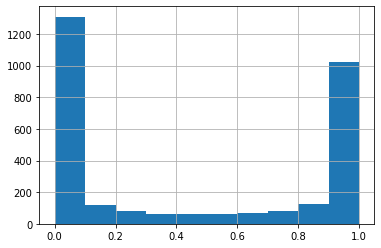

In [17]:
df['phase'] = df['wsi'].str.split('_').str[0]
t = df[df['phase'] == 'test']
t['prob'].hist()

In [31]:
df['phase'] = df['wsi'].str.split('_').str[0]

for th in np.arange(0.05, 0.51, 0.05):
    df_sub = df[(df['prob'] < th) | (df['prob'] > 1 - th)]
    df_sub['wsi_prob'] = df_sub.groupby('wsi')['pred'].transform('mean')
    df_sub['wsi_pred'] = (df_sub['wsi_prob'] > 0.5).astype(int)
    
    a1 = df_sub[df_sub['phase'] == 'training']
    b1 = df_sub[df_sub['phase'] == 'validation']
    a = a1[['wsi', 'msi', 'wsi_prob', 'wsi_pred']].drop_duplicates()
    b = b1[['wsi', 'msi', 'wsi_prob', 'wsi_pred']].drop_duplicates()
    
    a_auc = sklearn.metrics.roc_auc_score(a['msi'], a['wsi_prob'])
    b_auc = sklearn.metrics.roc_auc_score(b['msi'], b['wsi_prob'])
    a_f1 = sklearn.metrics.f1_score(a['msi'], a['wsi_pred'])
    b_f1 = sklearn.metrics.f1_score(b['msi'], b['wsi_pred'])
    a_pos = (a['wsi_pred'] == 1).sum()
    
#     print(np.round(th, 2), 'training\t', np.round(a_auc, 3), np.round(a_f1, 3))
    print('th =', np.round(th, 2), '\tP=', a_pos, '\tAUC =', np.round(b_auc, 3), '\tF1 =', np.round(b_f1, 3))

th = 0.05 	P= 12 	AUC = 0.92 	F1 = 0.769
th = 0.1 	P= 12 	AUC = 0.913 	F1 = 0.769
th = 0.15 	P= 12 	AUC = 0.906 	F1 = 0.769
th = 0.2 	P= 12 	AUC = 0.899 	F1 = 0.769
th = 0.25 	P= 12 	AUC = 0.906 	F1 = 0.714
th = 0.3 	P= 12 	AUC = 0.906 	F1 = 0.714
th = 0.35 	P= 12 	AUC = 0.906 	F1 = 0.714
th = 0.4 	P= 12 	AUC = 0.906 	F1 = 0.714
th = 0.45 	P= 12 	AUC = 0.906 	F1 = 0.714
th = 0.5 	P= 12 	AUC = 0.906 	F1 = 0.714


In [19]:
t = df[df['phase'] == 'training']

df_wsi = t[['wsi', 'msi', 'wsi_prob', 'wsi_pred']].drop_duplicates()

print('AUC={:.3f} F1={:.3f}'.format(
    sklearn.metrics.roc_auc_score(df_wsi['msi'], df_wsi['wsi_prob']),
    sklearn.metrics.f1_score(df_wsi['msi'], df_wsi['wsi_pred'])))
print(df_wsi['wsi_pred'].value_counts())
df_wsi.sort_values('wsi_prob')

KeyError: "['wsi_pred', 'wsi_prob'] not in index"

### Save results

In [82]:
t = df_wsi[['wsi', 'wsi_pred']]
t.columns = ['WSI_ID', 'MSI-H']
# t.to_csv('../result_test/test_MS_data47/validation_MSI.csv', index=False)

### AUC

[0.         0.16666667 0.5        0.5        0.83333333 0.83333333
 1.         1.        ]
[1.         1.         1.         0.91304348 0.91304348 0.56521739
 0.56521739 0.        ]


(-0.05, 1.05)

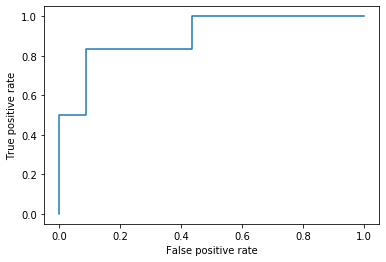

In [13]:
t = df_wsi

fpr, tpr, thresholds = sklearn.metrics.roc_curve(t['msi'], t['wsi_prob'])
print(tpr)
print(1 - fpr)

plt.step(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

### Precision, Recall

F1 = 0.8


(-0.05, 1.05)

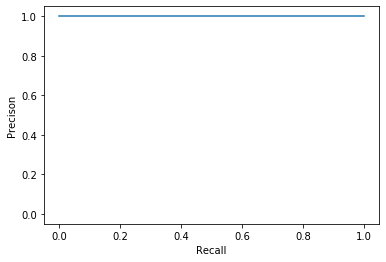

In [18]:
t = df_wsi[df_wsi['dataset'] == 'val']
# t = df_wsi

precision, recall, thresholds = sklearn.metrics.precision_recall_curve(t['msi'], t['wsi_prob'])
print('F1 =', sklearn.metrics.f1_score(t['msi'], t['wsi_pred']))

plt.step(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precison')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

In [45]:
print(recall)
print(precision)

[1.         0.66666667 0.33333333 0.         0.        ]
[0.75       0.66666667 0.5        0.         1.        ]


# Inference with augmentation

In [21]:
%%time

df_aug = pmodel.inference_augment('../data/dataset_validation/summary_patch_level2_level1.csv')

print(df_aug.shape)
df_aug.head(1)

True 0
True 45
True 90
True 135
True 180
True 225
True 270
True 315
False 0
False 45
False 90
False 135
False 180
False 225
False 270
False 315
(13104, 12)
Wall time: 8min 47s


,wsi,msi,prob,loss,x,y,pred,wsi_prob,wsi_pred,flip,rotate,wsi_aug
0,training_data_36,0,0.05111,0.162757,28672,32768,0,0.032787,0,1,0,training_data_36_1_0


In [22]:
fname = '../model/MS_2.5X_10X/20200903_1331_infer_aug.csv'
# df_aug.to_csv(fname, index=False)
# df_aug = pd.read_csv(fname)

print(df_aug.shape)
df_aug.head(1)

(13104, 12)


,wsi,msi,prob,loss,x,y,pred,wsi_prob,wsi_pred,flip,rotate,wsi_aug
0,training_data_36,0,0.05111,0.162757,28672,32768,0,0.032787,0,1,0,training_data_36_1_0


#### no augmentation

In [13]:
b = pd.read_csv('../result/validation_2.5X_47/validation_MSI.csv')
b = b.loc[b['MSI-H'] == 1, 'WSI_ID'].tolist()
b

# t = df_aug[(~ df_aug['flip']) & (df_aug['rotate'] == 0)]
# t = t[['wsi', 'wsi_prob', 'wsi_pred']].drop_duplicates()
# t['true'] = t['wsi'].isin(b)

# print(t['wsi_pred'].value_counts())
# t.sort_values('wsi_prob')

['validation_data_01',
 'validation_data_02',
 'validation_data_03',
 'validation_data_04',
 'validation_data_06',
 'validation_data_11',
 'validation_data_12',
 'validation_data_13',
 'validation_data_15',
 'validation_data_18',
 'validation_data_27',
 'validation_data_28',
 'validation_data_31']

#### all mean

In [25]:
t = df_aug.groupby(['wsi', 'msi'])['pred'].mean().sort_values().to_frame('prob').reset_index()

# t = df_aug.groupby('wsi')['pred'].mean().sort_values().to_frame('prob').reset_index()
# t['true'] = t['wsi'].isin(b)

t['pred'] = (t['prob'] > 0.5).astype(int)
print(t['pred'].value_counts())
t

0    8
1    4
Name: pred, dtype: int64


,wsi,msi,prob,pred
0,training_data_37,0,0.031250,0
1,training_data_43,0,0.033245,0
2,training_data_36,0,0.039959,0
3,training_data_38,0,0.062500,0
4,training_data_41,0,0.164286,0
5,training_data_46,0,0.180760,0
6,training_data_40,0,0.222500,0
7,training_data_39,0,0.241319,0
8,training_data_44,1,0.525187,1
9,training_data_45,0,0.625000,1


#### wsi mean

In [67]:
t = df_aug.groupby(['wsi', 'wsi_aug', 'msi'])['pred'].mean().sort_values().to_frame('prob').reset_index()
t['pred'] = (t['prob'] > 0.5).astype(int)
t = t.groupby(['wsi', 'msi'])['pred'].mean().sort_values().to_frame('prob').reset_index()
t['pred'] = (t['prob'] > 0.5).astype(int)


print(t['pred'].value_counts())
t

0    8
1    4
Name: pred, dtype: int64


,wsi,msi,prob,pred
0,training_data_36,0,0.0000,0
1,training_data_37,0,0.0000,0
2,training_data_38,0,0.0000,0
3,training_data_39,0,0.0000,0
4,training_data_40,0,0.0000,0
5,training_data_41,0,0.0000,0
6,training_data_43,0,0.0000,0
7,training_data_46,0,0.0000,0
8,training_data_44,1,0.6875,1
9,training_data_45,0,0.6875,1


#### patch mean

In [65]:
t = df_aug.groupby(['wsi', 'x', 'y'])['pred'].mean().sort_values().to_frame('prob').reset_index()
t['pred'] = (t['prob'] > 0.5).astype(int)
t = t.groupby(['wsi'])['pred'].mean().sort_values().to_frame('prob').reset_index()
t['pred'] = (t['prob'] > 0.5).astype(int)


print(t['pred'].value_counts())
t

0    8
1    4
Name: pred, dtype: int64


,wsi,prob,pred
0,training_data_38,0.000000,0
1,training_data_37,0.009434,0
2,training_data_43,0.021277,0
3,training_data_36,0.032787,0
4,training_data_41,0.142857,0
5,training_data_46,0.176471,0
6,training_data_40,0.200000,0
7,training_data_39,0.250000,0
8,training_data_44,0.507463,1
9,training_data_45,0.666667,1


In [58]:
df_aug_wsi = df_aug[['wsi', 'wsi_aug', 'flip', 'rotate', 'wsi_prob']].drop_duplicates()
df_aug_wsi.sort_values('wsi_prob', ascending=False)

# t = pd.read_csv('../data/dataset/summary_wsi.csv')
# df_aug_wsi = pd.merge(df_aug_wsi, t, how='left')

df_aug_wsi['wsi_id'] = df_aug_wsi['wsi'].str.split('_').str[-1].astype(int)

print(df_aug_wsi.shape)
df_aug_wsi.head(1)

(192, 6)


,wsi,wsi_aug,flip,rotate,wsi_prob,wsi_id
0,training_data_36,training_data_36_1_0,1,0,0.032787,36


Text(0.5, 1.0, 'train')

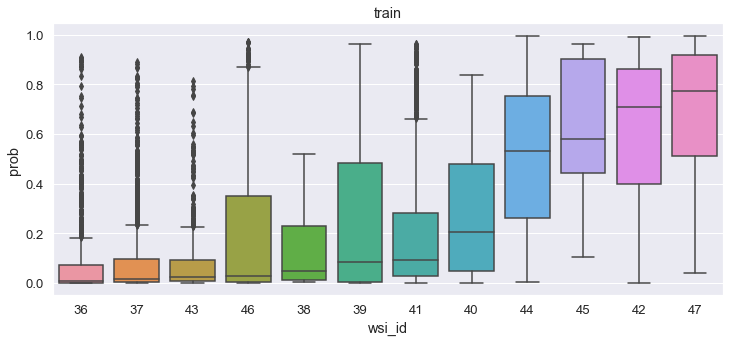

In [64]:
# t = df_aug_wsi[df_aug_wsi['dataset'] == 'train']
t = df_aug
t['wsi_id'] = t['wsi'].str[-2:].astype(int)

t2 = t.groupby('wsi_id')['prob'].median()
t2.sort_values(inplace=True)

sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
g = sns.boxplot(data=t, x='wsi_id', y='prob', order=t2.index)
g.set_title('train')

# Assemble patches

In [30]:
def assemble_patch_prob(df, level, size=256, figsize=(8, 8), wsisize=None):
    zoom = (4 ** level) * size
    
    if wsisize is None:
        range_x = (df['x'].min(), df['x'].max())
        range_y = (df['y'].min(), df['y'].max())
    else:
        range_x = (0, wsisize[0])
        range_y = (0, wsisize[1])
            
    img = np.full((
        (range_y[1] - range_y[0]) // zoom + 1,
        (range_x[1] - range_x[0]) // zoom + 1), 
        0.5)


    for i, row in df.iterrows():
        xnew = (row['x'] - range_x[0]) // zoom
        ynew = (row['y'] - range_y[0]) // zoom

        if ynew <= img.shape[0] and xnew <= img.shape[1]:
            img[ynew, xnew] = row['prob']
            
    plt.figure(figsize=figsize)
    ax = sns.heatmap(img, 
                cmap=matplotlib.cm.get_cmap('seismic'), 
                vmin=0, vmax=1, 
                xticklabels=[], yticklabels=[],
                cbar_kws={'shrink': 0.5}
               )
    ax.set_aspect('equal')
    
    for _, spine in ax.spines.items():
        spine.set_visible(True)

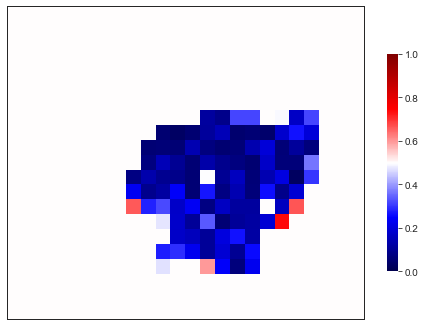

In [34]:
t = df[df['wsi'] == 'training_data_35']
assemble_patch_prob(t, 2, 256, wsisize=(95616, 85702))